Install necessary libraries

In [ ]:
# !pip install diffusers
# !pip install torch
# !pip install transformers
# !pip install torchvision
# !pip install peft
# !pip install accelerate


Convert  the training Imgage to the (512,512) shape

In [ ]:
# import os
# from PIL import Image
# import cv2
# for image_path in os.listdir('CP_Portrait'):
#     image = cv2.imread(f'/home/arkadeep_2101ai41/SD/CP_Portrait/{image_path}')
#     image=cv2.resize(image, (512, 512)) 
#     cv2.imwrite(f'/home/arkadeep_2101ai41/SD/CP_Portrait/{image_path}', image)



Load the individual module of the stable diffusion models and apply Lora adapters on them

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import AutoTokenizer, CLIPTextModel
from peft import LoraConfig, get_peft_model, PeftModel
from torchvision import transforms
import os
from PIL import Image
import os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define LORA parameters
UNET_TARGET_MODULES = ["to_q", "to_v", "query", "value"]
TEXT_ENCODER_TARGET_MODULES = ["q_proj", "v_proj"]
VAE_TARGET_MODULES   = ["to_q", "to_k", "to_v"]
UNET_LORA_CONFIG = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=UNET_TARGET_MODULES,
    lora_dropout=0.05,
    bias="none"
)
TEXT_ENCODER_LORA_CONFIG = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=TEXT_ENCODER_TARGET_MODULES,
    lora_dropout=0.05,
    bias="none"
)
VAE_LORA_CONFIG = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=VAE_TARGET_MODULES,
    lora_dropout=0.05,
    bias="none"
)
# **************************************************************************************************************************
# Load pre-trained models
model_id = "runwayml/stable-diffusion-v1-5"
tokenizer = AutoTokenizer.from_pretrained(model_id,subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(device)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)
# **************************************************************************************************************************
# Freeze Unet
unet.requires_grad_(False)
# Freeze Text Encoder
text_encoder.requires_grad_(False)
# Freeze VAE
vae.requires_grad_(False)
# Apply LORA to models
unet = get_peft_model(unet, UNET_LORA_CONFIG)
text_encoder = get_peft_model(text_encoder, TEXT_ENCODER_LORA_CONFIG)
vae= get_peft_model(vae, VAE_LORA_CONFIG)

/home/arkadeep_2101ai41/miniconda3/envs/explain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The training code

In [2]:
# Set up scheduler
noise_scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Define dataset and dataloader
class DreamBoothDataset(Dataset):
    def __init__(self, image_dir, caption, transform=None):
        self.image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.caption = caption
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        
        return image.to(device), self.caption

# Specify the folder containing images and the caption
image_dir = "Sketch3"
caption = "A photo of in the style of **"

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = DreamBoothDataset(image_dir, caption, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Training loop
optimizer = torch.optim.Adam(list(unet.parameters()) + list(text_encoder.parameters()), lr=1e-4)

num_epochs = 100

#training loop

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, total=len(dataloader))
    for images, captions in progress_bar:
        optimizer.zero_grad()
        if(images.shape[0]==1):
            images=torch.cat([images,images,images,images],dim=0)

        # Encode text
        captions = tokenizer(captions, padding=True, return_tensors="pt").input_ids.to(device)
        encoder_hidden_states = text_encoder(captions)[0]

        # Encode images to latent space
        latents = vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215  # Scaling factor for Stable Diffusion

        # Sample noise and timesteps
        noise = torch.randn_like(latents).to(device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (latents.shape[0],), device=device)
        # Add noise to latents
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise residual
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # Compute loss
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

        loss = torch.nn.functional.mse_loss(noise_pred.float(), target.float(), reduction="mean")

        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item())

# Save the trained models
output_dir = "demo_trained_model_sketch3"
os.makedirs(output_dir, exist_ok=True)
unet_dir = os.path.join(output_dir, "unet")
text_encoder_dir = os.path.join(output_dir, "text_encoder")

os.makedirs(unet_dir, exist_ok=True)
os.makedirs(text_encoder_dir, exist_ok=True)


unet.save_pretrained(output_dir+"/unet")
text_encoder.save_pretrained(output_dir+"/text_encoder")
vae.save_pretrained(output_dir+"/vae")

  0%|          | 0/3 [00:00<?, ?it/s]/home/arkadeep_2101ai41/miniconda3/envs/explain/lib/python3.10/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
  0%|          | 0/3 [00:01<?, ?it/s]


KeyboardInterrupt: 

Load the fine-tuned model for inference

In [3]:
from diffusers import UNet2DConditionModel, AutoencoderKL, DiffusionPipeline
from transformers import AutoTokenizer, CLIPTextModel
from peft import LoraConfig, get_peft_model, PeftModel
import torch
from transformers import CLIPTextModel

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "runwayml/stable-diffusion-v1-5"
tokenizer = AutoTokenizer.from_pretrained(model_id,subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# Load the trained models
unet_id="trained_model_sketch3/unet"
text_encoder_id="trained_model_sketch3/text_encoder"
vae_id="trained_model_sketch3/vae"
unet=PeftModel.from_pretrained(unet, unet_id)
text_encoder=PeftModel.from_pretrained(text_encoder, text_encoder_id)
vae=PeftModel.from_pretrained(vae, vae_id)



Setup the pipeline for text to image generation

In [4]:
pipeline = DiffusionPipeline.from_pretrained(model_id, unet=unet.base_model.model, text_encoder=text_encoder.base_model.model, vae=vae)
pipeline.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 24.65it/s]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Generate images (mention "in the style of **" to get image which follow the style, else the model would return normal images which need not follow the specific style.)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


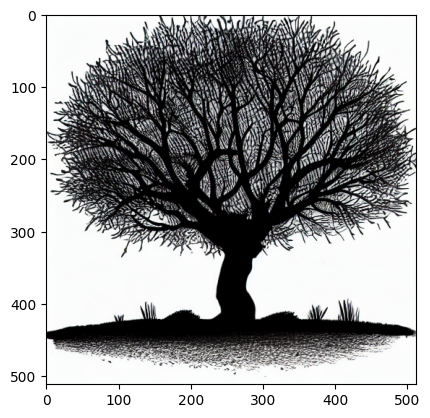

In [11]:
import matplotlib.pyplot as plt
prompt = "A photo of a tree in the style of **."
image = pipeline(prompt).images[0]
plt.imshow(image)


Load the Image2Image diffusion pipeline for style transfer.

In [12]:
from diffusers import StableDiffusionImg2ImgPipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, unet=unet.base_model.model, text_encoder=text_encoder.base_model.model, vae=vae,safety_checker=None)
pipe.to('cuda')

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 108.07it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Generate style transfered outputs

/home/arkadeep_2101ai41/miniconda3/envs/explain/lib/python3.10/site-packages/diffusers/image_processor.py:542: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 35/35 [00:08<00:00,  4.01it/s]


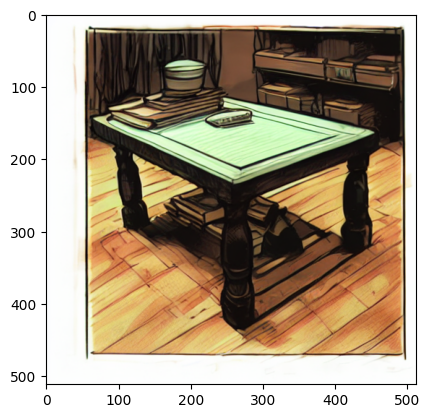

In [15]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

init_image = Image.open("./table.png").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
init_image = transform(init_image)
prompt = "A photo in the style of **"

image = pipe(prompt=prompt, image=init_image, strength=0.7, guidance_scale=7.5).images
plt.imshow(image[0])